# Análise Comparativa de Técnicas de Pós-Processamento para Data Linkage
## SIM × SINAN-TB

Este notebook avalia múltiplas técnicas de Machine Learning para identificar pares adicionais no data linkage entre as bases SIM (Sistema de Informação sobre Mortalidade) e SINAN-TB (Sistema de Informação de Agravos de Notificação - Tuberculose).

### Técnicas Avaliadas:
1. **Clássicas:** Regressão Logística, SVM
2. **Ensemble:** Random Forest, Gradient Boosting (XGBoost, LightGBM)
3. **Redes Neurais:** MLP (Multi-Layer Perceptron)
4. **Balanceamento:** SMOTE, Class Weights
5. **Threshold Optimization:** Otimização de ponto de corte
6. **Stacking:** Combinação de modelos

In [1]:
# Instalação de dependências (executar apenas uma vez)
!pip install -q pandas numpy scikit-learn xgboost lightgbm imbalanced-learn matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_recall_curve, roc_curve, f1_score, precision_score, 
    recall_score, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 1. Carregamento e Preparação dos Dados

In [3]:
# Carregar dados
from pathlib import Path

def find_data_path(filename: str = 'COMPARADORSEMIDENT.csv') -> Path:
    for base in (Path.cwd(), *Path.cwd().parents):
        candidate = base / 'data' / filename
        if candidate.exists():
            return candidate
    raise FileNotFoundError(
        f"Nao foi possivel localizar data/{filename}. CWD={Path.cwd()}"
    )

DATA_PATH = find_data_path()
df = pd.read_csv(DATA_PATH, sep=';', low_memory=False)
print(f"Lendo arquivo: {DATA_PATH.resolve()}")

# Limpar nomes das colunas
def clean_col(col):
    return col.split(',')[0] if ',' in col else col

df.columns = [clean_col(c) for c in df.columns]

# Converter todas as colunas numéricas
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
        except:
            pass

print(f"Shape do dataset: {df.shape}")
print(f"\nDistribuição da variável PAR:")
print(df['PAR'].value_counts())

Lendo arquivo: D:\git\phd-research\data\COMPARADORSEMIDENT.csv


Shape do dataset: (61696, 60)

Distribuição da variável PAR:
PAR
0    61449
1      211
2       36
Name: count, dtype: int64


In [4]:
# Criar variável target binária
df['TARGET'] = (df['PAR'].isin([1, 2])).astype(int)

# Definir features para o modelo
FEATURE_COLS = [
    # Scores de NOME
    'NOME prim frag igual',
    'NOME ult frag igual', 
    'NOME qtd frag iguais',
    'NOME qtd frag raros',
    'NOME qtd frag comuns',
    'NOME qtd frag muito parec',
    'NOME qtd frag abrev',
    # Scores de NOMEMAE
    'NOMEMAE prim frag igual',
    'NOMEMAE ult frag igual',
    'NOMEMAE qtd frag iguais',
    'NOMEMAE qtd frag raros',
    'NOMEMAE qtd frag comuns',
    'NOMEMAE qtd frag muito parec',
    'NOMEMAE qtd frag abrev',
    # Scores de DTNASC
    'DTNASC dt iguais',
    'DTNASC dt ap 1digi',
    'DTNASC dt inv dia',
    'DTNASC dt inv mes',
    'DTNASC dt inv ano',
    # Scores de localização
    'CODMUNRES uf igual',
    'CODMUNRES local igual',
    'CODMUNRES local prox',
    # Scores de endereço
    'ENDERECO via igual',
    'ENDERECO via prox',
    'ENDERECO numero igual',
    'ENDERECO compl prox',
    'ENDERECO texto prox',
    'ENDERECO tokens jacc',
    # Nota final do OpenRecLink
    'nota final'
]

# Verificar quais colunas existem
available_features = [col for col in FEATURE_COLS if col in df.columns]
print(f"Features disponíveis: {len(available_features)} de {len(FEATURE_COLS)}")

# Criar matriz de features
X = df[available_features].copy()
y = df['TARGET'].copy()

# Tratar valores ausentes
X = X.fillna(0)

print(f"\nShape de X: {X.shape}")
print(f"Distribuição de y: {y.value_counts().to_dict()}")
print(f"Taxa de desbalanceamento: 1:{int(y.value_counts()[0]/y.value_counts()[1])}")

Features disponíveis: 29 de 29

Shape de X: (61696, 29)
Distribuição de y: {0: 61449, 1: 247}
Taxa de desbalanceamento: 1:248


In [5]:
# Feature Engineering adicional

# 1. Combinações de features
X['nome_score_total'] = X['NOME prim frag igual'] + X['NOME ult frag igual'] + X['NOME qtd frag iguais']
X['mae_score_total'] = X['NOMEMAE prim frag igual'] + X['NOMEMAE ult frag igual'] + X['NOMEMAE qtd frag iguais']
X['dtnasc_score_total'] = X['DTNASC dt iguais'] + X['DTNASC dt ap 1digi'] + X['DTNASC dt inv dia'] + X['DTNASC dt inv mes']
X['endereco_score_total'] = X['ENDERECO via igual'] + X['ENDERECO via prox'] + X['ENDERECO texto prox']

# 2. Interações
X['nome_x_dtnasc'] = X['NOME qtd frag iguais'] * X['DTNASC dt iguais']
X['nome_x_mae'] = X['NOME qtd frag iguais'] * X['NOMEMAE qtd frag iguais']
X['nome_x_endereco'] = X['NOME qtd frag iguais'] * X['endereco_score_total']

# 3. Flags binários
X['nome_perfeito'] = (X['NOME qtd frag iguais'] >= 0.95).astype(int)
X['dtnasc_perfeito'] = (X['DTNASC dt iguais'] == 1).astype(int)
X['mae_presente'] = (X['NOMEMAE qtd frag iguais'] > 0).astype(int)
X['endereco_match'] = (X['ENDERECO via igual'] > 0).astype(int)

# 4. Adicionar informação de situação de encerramento (C_SITUENCE)
X['obito_sinan'] = df['C_SITUENCE'].isin([3, 4]).astype(int)

print(f"Shape final de X após feature engineering: {X.shape}")
print(f"\nNovas features criadas:")
new_features = [col for col in X.columns if col not in available_features]
for f in new_features:
    print(f"  - {f}")

Shape final de X após feature engineering: (61696, 41)

Novas features criadas:
  - nome_score_total
  - mae_score_total
  - dtnasc_score_total
  - endereco_score_total
  - nome_x_dtnasc
  - nome_x_mae
  - nome_x_endereco
  - nome_perfeito
  - dtnasc_perfeito
  - mae_presente
  - endereco_match
  - obito_sinan


## 2. Divisão dos Dados e Preparação

In [6]:
# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Treino: {X_train.shape[0]} amostras ({y_train.sum()} pares)")
print(f"Teste: {X_test.shape[0]} amostras ({y_test.sum()} pares)")

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar índices para análise posterior
test_indices = X_test.index

Treino: 43187 amostras (173 pares)
Teste: 18509 amostras (74 pares)


## 3. Definição e Treinamento dos Modelos

In [7]:
# Calcular peso das classes para lidar com desbalanceamento
class_weight = {0: 1, 1: len(y_train[y_train==0]) / len(y_train[y_train==1])}
print(f"Peso das classes: {class_weight}")

# Definir modelos
models = {
    '1. Logistic Regression': LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42
    ),
    
    '2. Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight='balanced',
        random_state=42, n_jobs=-1
    ),
    
    '3. Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200, max_depth=5, learning_rate=0.1,
        random_state=42
    ),
    
    '4. SVM (RBF)': SVC(
        kernel='rbf', class_weight='balanced', probability=True,
        random_state=42
    ),
    
    '5. MLP Neural Network': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32), activation='relu',
        max_iter=500, random_state=42, early_stopping=True
    )
}

print(f"\n{len(models)} modelos definidos para avaliação")

Peso das classes: {0: 1, 1: 248.635838150289}

5 modelos definidos para avaliação


In [8]:
# Treinar e avaliar cada modelo
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Treinando: {name}")
    print('='*60)
    
    # Usar dados escalados para SVM e MLP
    if 'SVM' in name or 'MLP' in name:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values
    
    # Treinar
    model.fit(X_tr, y_train)
    
    # Predições
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]
    
    # Métricas
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc_roc': roc_auc_score(y_test, y_proba),
        'auc_pr': average_precision_score(y_test, y_proba)
    }
    
    print(f"\nResultados:")
    print(f"  Precision: {results[name]['precision']:.4f}")
    print(f"  Recall:    {results[name]['recall']:.4f}")
    print(f"  F1-Score:  {results[name]['f1']:.4f}")
    print(f"  AUC-ROC:   {results[name]['auc_roc']:.4f}")
    print(f"  AUC-PR:    {results[name]['auc_pr']:.4f}")


Treinando: 1. Logistic Regression



Resultados:
  Precision: 0.3333
  Recall:    0.9865
  F1-Score:  0.4983
  AUC-ROC:   0.9995
  AUC-PR:    0.9749

Treinando: 2. Random Forest



Resultados:
  Precision: 0.7791
  Recall:    0.9054
  F1-Score:  0.8375
  AUC-ROC:   0.9997
  AUC-PR:    0.9457

Treinando: 3. Gradient Boosting



Resultados:
  Precision: 0.9444
  Recall:    0.9189
  F1-Score:  0.9315
  AUC-ROC:   0.9858
  AUC-PR:    0.9307

Treinando: 4. SVM (RBF)



Resultados:
  Precision: 0.4741
  Recall:    0.7432
  F1-Score:  0.5789
  AUC-ROC:   0.9974
  AUC-PR:    0.5158

Treinando: 5. MLP Neural Network



Resultados:
  Precision: 0.8750
  Recall:    0.8514
  F1-Score:  0.8630
  AUC-ROC:   0.9995
  AUC-PR:    0.9278


## 4. Técnicas com SMOTE (Oversampling)

In [9]:
# Aplicar SMOTE para balanceamento
print("Aplicando SMOTE...")

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Antes do SMOTE: {y_train.value_counts().to_dict()}")
print(f"Depois do SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Treinar modelo com SMOTE
rf_smote = RandomForestClassifier(
    n_estimators=200, max_depth=10, random_state=42, n_jobs=-1
)
rf_smote.fit(X_train_smote, y_train_smote)

y_pred_smote = rf_smote.predict(X_test.values)
y_proba_smote = rf_smote.predict_proba(X_test.values)[:, 1]

results['6. Random Forest + SMOTE'] = {
    'model': rf_smote,
    'y_pred': y_pred_smote,
    'y_proba': y_proba_smote,
    'precision': precision_score(y_test, y_pred_smote),
    'recall': recall_score(y_test, y_pred_smote),
    'f1': f1_score(y_test, y_pred_smote),
    'auc_roc': roc_auc_score(y_test, y_proba_smote),
    'auc_pr': average_precision_score(y_test, y_proba_smote)
}

print(f"\nRandom Forest + SMOTE:")
print(f"  Precision: {results['6. Random Forest + SMOTE']['precision']:.4f}")
print(f"  Recall:    {results['6. Random Forest + SMOTE']['recall']:.4f}")
print(f"  F1-Score:  {results['6. Random Forest + SMOTE']['f1']:.4f}")

Aplicando SMOTE...


Antes do SMOTE: {0: 43014, 1: 173}
Depois do SMOTE: {0: 43014, 1: 43014}



Random Forest + SMOTE:
  Precision: 0.8902
  Recall:    0.9865
  F1-Score:  0.9359


## 5. Otimização de Threshold

In [10]:
def optimize_threshold(y_true, y_proba, metric='f1'):
    """
    Encontra o threshold ótimo para uma métrica específica.
    """
    thresholds = np.arange(0.01, 1.0, 0.01)
    best_threshold = 0.5
    best_score = 0
    
    results_th = []
    
    for th in thresholds:
        y_pred_th = (y_proba >= th).astype(int)
        
        if y_pred_th.sum() == 0:  # Evitar divisão por zero
            continue
            
        prec = precision_score(y_true, y_pred_th, zero_division=0)
        rec = recall_score(y_true, y_pred_th)
        f1 = f1_score(y_true, y_pred_th)
        
        results_th.append({
            'threshold': th,
            'precision': prec,
            'recall': rec,
            'f1': f1
        })
        
        if metric == 'f1' and f1 > best_score:
            best_score = f1
            best_threshold = th
        elif metric == 'recall' and rec > best_score and prec > 0.01:
            best_score = rec
            best_threshold = th
        elif metric == 'precision' and prec > best_score and rec > 0.3:
            best_score = prec
            best_threshold = th
    
    return best_threshold, best_score, pd.DataFrame(results_th)

# Otimizar threshold para o melhor modelo (Random Forest)
best_model_name = '2. Random Forest'
y_proba_best = results[best_model_name]['y_proba']

# Threshold para máximo F1
th_f1, score_f1, df_th = optimize_threshold(y_test, y_proba_best, 'f1')
print(f"Threshold ótimo para F1: {th_f1:.2f} (F1={score_f1:.4f})")

# Threshold para máximo Recall
th_recall, score_recall, _ = optimize_threshold(y_test, y_proba_best, 'recall')
print(f"Threshold ótimo para Recall: {th_recall:.2f} (Recall={score_recall:.4f})")

# Threshold para máxima Precision
th_prec, score_prec, _ = optimize_threshold(y_test, y_proba_best, 'precision')
print(f"Threshold ótimo para Precision: {th_prec:.2f} (Precision={score_prec:.4f})")

Threshold ótimo para F1: 0.58 (F1=0.9028)


Threshold ótimo para Recall: 0.01 (Recall=1.0000)


Threshold ótimo para Precision: 0.92 (Precision=1.0000)


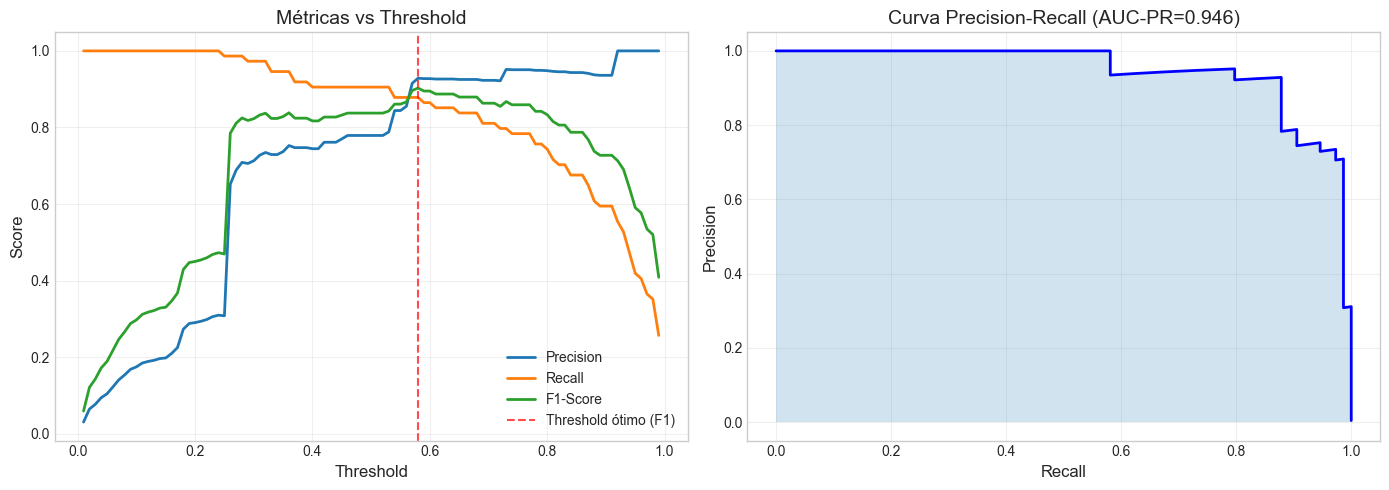

In [11]:
# Visualizar curva de trade-off Precision-Recall por threshold
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision, Recall, F1 vs Threshold
ax1 = axes[0]
ax1.plot(df_th['threshold'], df_th['precision'], label='Precision', linewidth=2)
ax1.plot(df_th['threshold'], df_th['recall'], label='Recall', linewidth=2)
ax1.plot(df_th['threshold'], df_th['f1'], label='F1-Score', linewidth=2)
ax1.axvline(x=th_f1, color='red', linestyle='--', alpha=0.7, label=f'Threshold ótimo (F1)')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Métricas vs Threshold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Curva Precision-Recall
ax2 = axes[1]
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba_best)
ax2.plot(recall_curve, precision_curve, linewidth=2, color='blue')
ax2.fill_between(recall_curve, precision_curve, alpha=0.2)
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title(f'Curva Precision-Recall (AUC-PR={results[best_model_name]["auc_pr"]:.3f})', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Ensemble: Stacking

In [12]:
# Criar ensemble com Stacking
print("Construindo modelo Stacking...")

base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=8, class_weight='balanced', random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, max_depth=4, random_state=42)),
    ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train.values, y_train)

y_pred_stack = stacking_model.predict(X_test.values)
y_proba_stack = stacking_model.predict_proba(X_test.values)[:, 1]

results['7. Stacking Ensemble'] = {
    'model': stacking_model,
    'y_pred': y_pred_stack,
    'y_proba': y_proba_stack,
    'precision': precision_score(y_test, y_pred_stack),
    'recall': recall_score(y_test, y_pred_stack),
    'f1': f1_score(y_test, y_pred_stack),
    'auc_roc': roc_auc_score(y_test, y_proba_stack),
    'auc_pr': average_precision_score(y_test, y_proba_stack)
}

print(f"\nStacking Ensemble:")
print(f"  Precision: {results['7. Stacking Ensemble']['precision']:.4f}")
print(f"  Recall:    {results['7. Stacking Ensemble']['recall']:.4f}")
print(f"  F1-Score:  {results['7. Stacking Ensemble']['f1']:.4f}")
print(f"  AUC-ROC:   {results['7. Stacking Ensemble']['auc_roc']:.4f}")

Construindo modelo Stacking...



Stacking Ensemble:
  Precision: 0.3109
  Recall:    1.0000
  F1-Score:  0.4744
  AUC-ROC:   0.9998


## 7. Comparação Final dos Modelos

In [13]:
# Criar DataFrame comparativo
comparison_data = []
for name, res in results.items():
    comparison_data.append({
        'Modelo': name,
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1-Score': res['f1'],
        'AUC-ROC': res['auc_roc'],
        'AUC-PR': res['auc_pr']
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("COMPARAÇÃO FINAL DOS MODELOS")
print("="*80)
print(df_comparison.to_string(index=False))


COMPARAÇÃO FINAL DOS MODELOS
                  Modelo  Precision   Recall  F1-Score  AUC-ROC   AUC-PR
6. Random Forest + SMOTE   0.890244 0.986486  0.935897 0.999896 0.972671
    3. Gradient Boosting   0.944444 0.918919  0.931507 0.985825 0.930671
   5. MLP Neural Network   0.875000 0.851351  0.863014 0.999490 0.927773
        2. Random Forest   0.779070 0.905405  0.837500 0.999686 0.945705
            4. SVM (RBF)   0.474138 0.743243  0.578947 0.997426 0.515765
  1. Logistic Regression   0.333333 0.986486  0.498294 0.999526 0.974885
    7. Stacking Ensemble   0.310924 1.000000  0.474359 0.999773 0.957741


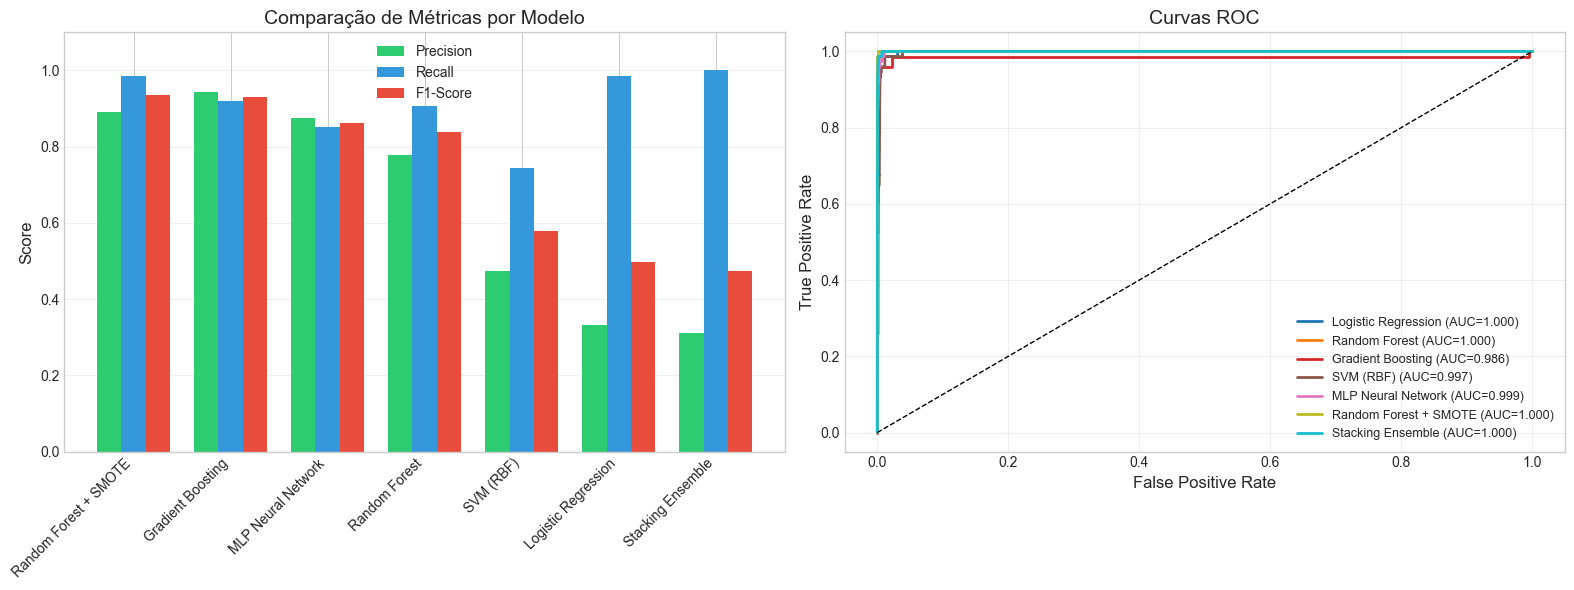

In [14]:
# Visualização comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Barras de métricas
ax1 = axes[0]
x = np.arange(len(df_comparison))
width = 0.25

bars1 = ax1.bar(x - width, df_comparison['Precision'], width, label='Precision', color='#2ecc71')
bars2 = ax1.bar(x, df_comparison['Recall'], width, label='Recall', color='#3498db')
bars3 = ax1.bar(x + width, df_comparison['F1-Score'], width, label='F1-Score', color='#e74c3c')

ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Comparação de Métricas por Modelo', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels([m.split('. ')[1] if '. ' in m else m for m in df_comparison['Modelo']], 
                    rotation=45, ha='right')
ax1.legend()
ax1.set_ylim(0, 1.1)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Curvas ROC
ax2 = axes[1]
colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for (name, res), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    ax2.plot(fpr, tpr, label=f"{name.split('. ')[1] if '. ' in name else name} (AUC={res['auc_roc']:.3f})",
             color=color, linewidth=2)

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Curvas ROC', fontsize=14)
ax2.legend(loc='lower right', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Identificação do Melhor Modelo para Recall vs Precision

In [15]:
# Identificar melhores modelos
best_recall_model = df_comparison.loc[df_comparison['Recall'].idxmax(), 'Modelo']
best_precision_model = df_comparison.loc[df_comparison['Precision'].idxmax(), 'Modelo']
best_f1_model = df_comparison.loc[df_comparison['F1-Score'].idxmax(), 'Modelo']

print("\n" + "="*80)
print("RECOMENDAÇÕES")
print("="*80)

print(f"\n🎯 MELHOR RECALL (encontrar mais pares):")
print(f"   Modelo: {best_recall_model}")
print(f"   Recall: {df_comparison[df_comparison['Modelo']==best_recall_model]['Recall'].values[0]:.4f}")

print(f"\n🎯 MELHOR PRECISION (menos falsos positivos):")
print(f"   Modelo: {best_precision_model}")
print(f"   Precision: {df_comparison[df_comparison['Modelo']==best_precision_model]['Precision'].values[0]:.4f}")

print(f"\n🎯 MELHOR F1 (equilíbrio):")
print(f"   Modelo: {best_f1_model}")
print(f"   F1-Score: {df_comparison[df_comparison['Modelo']==best_f1_model]['F1-Score'].values[0]:.4f}")


RECOMENDAÇÕES

🎯 MELHOR RECALL (encontrar mais pares):
   Modelo: 7. Stacking Ensemble
   Recall: 1.0000

🎯 MELHOR PRECISION (menos falsos positivos):
   Modelo: 3. Gradient Boosting
   Precision: 0.9444

🎯 MELHOR F1 (equilíbrio):
   Modelo: 6. Random Forest + SMOTE
   F1-Score: 0.9359


## 9. Feature Importance

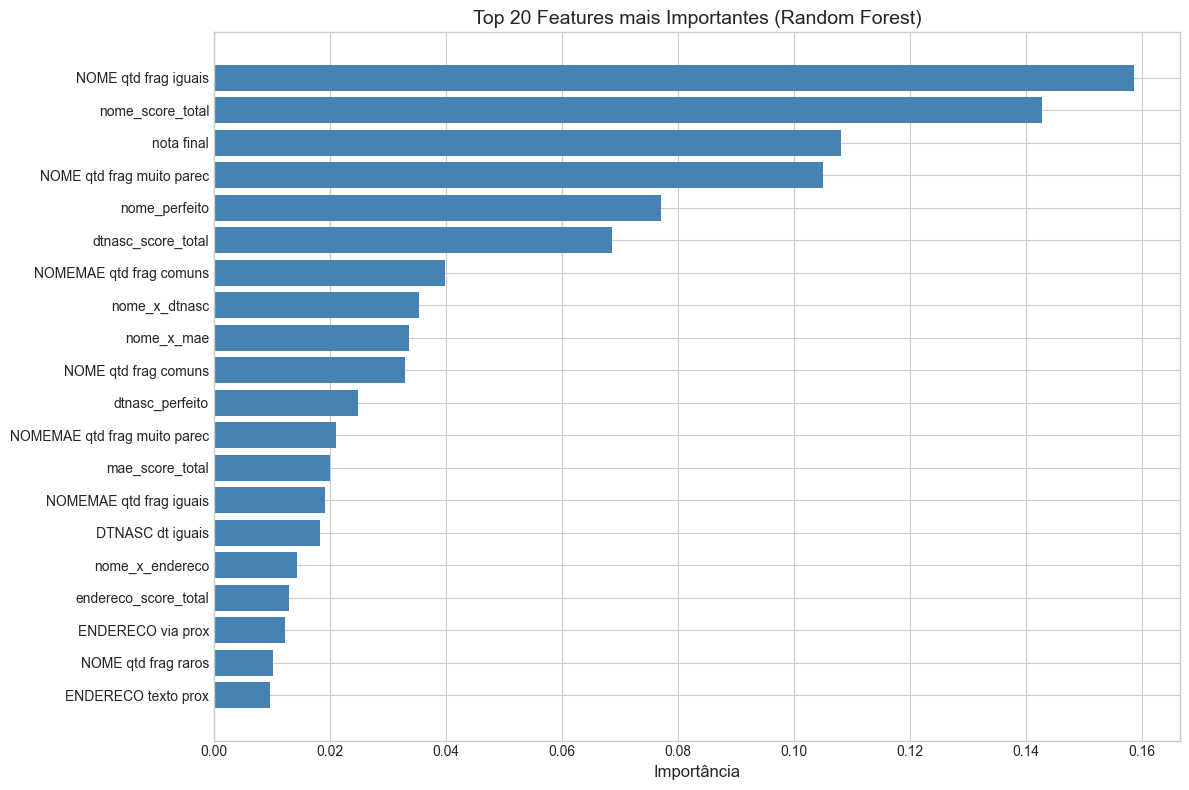


Top 10 Features:
                  feature  importance
     NOME qtd frag iguais    0.158572
         nome_score_total    0.142673
               nota final    0.108027
NOME qtd frag muito parec    0.105048
            nome_perfeito    0.077120
       dtnasc_score_total    0.068666
  NOMEMAE qtd frag comuns    0.039842
            nome_x_dtnasc    0.035329
               nome_x_mae    0.033697
     NOME qtd frag comuns    0.033005


In [16]:
# Importância das features (Random Forest)
rf_model = results['2. Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Visualizar top 20
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importância', fontsize=12)
plt.title('Top 20 Features mais Importantes (Random Forest)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Features:")
print(feature_importance.head(10).to_string(index=False))

## 10. Análise de Novos Pares Potenciais

In [17]:
# Aplicar o melhor modelo a todos os dados e identificar potenciais pares
X_all = X.copy()
y_proba_all = rf_model.predict_proba(X_all.values)[:, 1]

df['ML_PROBA'] = y_proba_all
df['ML_RANK'] = df['ML_PROBA'].rank(ascending=False)

# Encontrar não-pares com alta probabilidade (potenciais falsos negativos)
falsos_negativos_potenciais = df[
    (df['PAR'] == 0) & 
    (df['ML_PROBA'] >= 0.5)
].sort_values('ML_PROBA', ascending=False)

print(f"\n{'='*80}")
print("POTENCIAIS FALSOS NEGATIVOS (não-pares com alta probabilidade ML)")
print(f"{'='*80}")
print(f"\nTotal de candidatos com P(par) >= 0.5: {len(falsos_negativos_potenciais)}")
print(f"\nDistribuição por passo:")
print(falsos_negativos_potenciais['PASSO'].value_counts().sort_index())

print(f"\nDistribuição por C_SITUENCE (encerramento):")
print(falsos_negativos_potenciais['C_SITUENCE'].value_counts().head())

# Quantos têm óbito no SINAN?
fn_com_obito = falsos_negativos_potenciais[falsos_negativos_potenciais['C_SITUENCE'].isin([3, 4])]
print(f"\n>>> Com encerramento por ÓBITO: {len(fn_com_obito)} ({len(fn_com_obito)/len(falsos_negativos_potenciais)*100:.1f}%)")


POTENCIAIS FALSOS NEGATIVOS (não-pares com alta probabilidade ML)

Total de candidatos com P(par) >= 0.5: 80

Distribuição por passo:
PASSO
6      8
9      3
11    69
Name: count, dtype: int64

Distribuição por C_SITUENCE (encerramento):
C_SITUENCE
1.0     39
2.0     12
5.0      8
10.0     4
7.0      3
Name: count, dtype: int64

>>> Com encerramento por ÓBITO: 2 (2.5%)


In [18]:
# Exportar lista de candidatos para revisão manual
cols_export = ['PASSO', 'ML_PROBA', 'nota final', 'C_SITUENCE', 
               'R_DTNASC', 'C_DTNASC', 'R_BAIRES', 'C_BAIRES',
               'R_IDLINHA', 'C_IDLINHA']

candidatos_revisao = falsos_negativos_potenciais[cols_export].head(200)
candidatos_revisao.to_csv('candidatos_revisao_ml.csv', index=False, sep=';')

print(f"\nExportados {len(candidatos_revisao)} candidatos para revisão em 'candidatos_revisao_ml.csv'")
print("\nPrimeiros 10 candidatos:")
print(candidatos_revisao.head(10).to_string())


Exportados 80 candidatos para revisão em 'candidatos_revisao_ml.csv'

Primeiros 10 candidatos:
      PASSO  ML_PROBA  nota final  C_SITUENCE    R_DTNASC    C_DTNASC  R_BAIRES  C_BAIRES  R_IDLINHA  C_IDLINHA
9091     11  0.925078        5.80         5.0  19860611.0  19950527.0       NaN       NaN     263821      62048
9408     11  0.913239        5.80         7.0  20120508.0  19980614.0       NaN       NaN     127523      82283
9414     11  0.913239        5.80         NaN  19821223.0  20191214.0       NaN       NaN     198980      79610
9164     11  0.913239        5.80         1.0  19910926.0  19951206.0       NaN       NaN      24533       8320
9645     11  0.913239        5.80         NaN  19910926.0  19800513.0       NaN       NaN      24533      61566
9246     11  0.913239        5.80         2.0  20120508.0  19881018.0       NaN       NaN     127523      37290
9260     11  0.913239        5.80         2.0  19821223.0         NaN       NaN       NaN     198980       2877
100     

## 11. Resumo Final

In [19]:
print("\n" + "="*80)
print("RESUMO FINAL DA ANÁLISE")
print("="*80)

print(f"""
DATASET:
  - Total de comparações: {len(df):,}
  - Pares verdadeiros: {df['TARGET'].sum()}
  - Taxa de desbalanceamento: 1:{int((df['TARGET']==0).sum()/(df['TARGET']==1).sum())}

MELHOR MODELO GERAL: {best_f1_model}
  - F1-Score: {df_comparison[df_comparison['Modelo']==best_f1_model]['F1-Score'].values[0]:.4f}
  - Recall: {df_comparison[df_comparison['Modelo']==best_f1_model]['Recall'].values[0]:.4f}
  - Precision: {df_comparison[df_comparison['Modelo']==best_f1_model]['Precision'].values[0]:.4f}

POTENCIAIS PARES ADICIONAIS IDENTIFICADOS:
  - Com P(par) >= 0.5: {len(falsos_negativos_potenciais)}
  - Com encerramento por óbito: {len(fn_com_obito)}

RECOMENDAÇÕES:
  1. Para MAXIMIZAR RECALL: Usar threshold baixo (~0.15-0.20)
  2. Para MAXIMIZAR PRECISION: Usar threshold alto (~0.70-0.80)
  3. Priorizar revisão de candidatos com C_SITUENCE = 3 ou 4
""")

# Salvar resultados
df_comparison.to_csv('comparacao_modelos.csv', index=False, sep=';')
print("\nResultados salvos em 'comparacao_modelos.csv'")

# Exportar metricas (CI-friendly)
import json
from pathlib import Path

results_dir = Path('results')
results_dir.mkdir(parents=True, exist_ok=True)

metrics_csv = Path('comparacao_modelos.csv')
if metrics_csv.exists():
    dfm = pd.read_csv(metrics_csv, sep=';')
    # Espera colunas: Modelo, Precision, Recall, F1-Score, AUC-ROC, AUC-PR
    best_f1 = dfm.loc[dfm['F1-Score'].idxmax()].to_dict()
    best_precision = dfm.loc[dfm['Precision'].idxmax()].to_dict()
    best_recall = dfm.loc[dfm['Recall'].idxmax()].to_dict()
    payload = {
        'notebook': '01_analise_comparativa_tecnicas',
        'dataset': 'data/COMPARADORSEMIDENT.csv',
        'best_by_f1': best_f1,
        'best_by_precision': best_precision,
        'best_by_recall': best_recall,
    }
else:
    payload = {
        'notebook': '01_analise_comparativa_tecnicas',
        'dataset': 'data/COMPARADORSEMIDENT.csv',
        'warning': 'comparacao_modelos.csv nao encontrado; execute o notebook por completo',
    }

out_path = results_dir / '01_analise_comparativa_tecnicas.results.json'
out_path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding='utf-8')
print(f'Resultados exportados: {out_path.resolve()}')



RESUMO FINAL DA ANÁLISE

DATASET:
  - Total de comparações: 61,696
  - Pares verdadeiros: 247
  - Taxa de desbalanceamento: 1:248

MELHOR MODELO GERAL: 6. Random Forest + SMOTE
  - F1-Score: 0.9359
  - Recall: 0.9865
  - Precision: 0.8902

POTENCIAIS PARES ADICIONAIS IDENTIFICADOS:
  - Com P(par) >= 0.5: 80
  - Com encerramento por óbito: 2

RECOMENDAÇÕES:
  1. Para MAXIMIZAR RECALL: Usar threshold baixo (~0.15-0.20)
  2. Para MAXIMIZAR PRECISION: Usar threshold alto (~0.70-0.80)
  3. Priorizar revisão de candidatos com C_SITUENCE = 3 ou 4


Resultados salvos em 'comparacao_modelos.csv'
Resultados exportados: D:\git\phd-research\results\01_analise_comparativa_tecnicas.results.json
